 ##   INCIDENT MANAGEMENT  PROCESS IMPROVEMENT        

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime
%matplotlib inline
sns.set()

sns.set(style='ticks', context='notebook')
sns.set(font_scale=3.0)
plt.rcParams['figure.figsize'] = [30, 25]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
plt.rcParams["axes.labelsize"] = 30

In [48]:
#Loading data
file = 'incident_event_log.csv'
inc_event = pd.read_csv(file)



In [49]:
#coverting this data to a panda dataframe for further data wrangling

inc_eventdf = pd.DataFrame(inc_event)
pd.options.display.max_columns = None

In [50]:
#to replace missing value symbol '?' to NaN
inc_eventdf = inc_eventdf.replace(to_replace=['?'],value = [np.nan]) 

In [51]:
col_name = ['sys_created_at','opened_at','sys_updated_at','resolved_at','closed_at']
for i in range(len(col_name)):
    inc_eventdf[col_name[i]] = pd.to_datetime(inc_eventdf[col_name[i]], dayfirst = True)

In [52]:
# filling all the missing value in resolved_at colums with information in sys_updated_at
# sys_updated_at time corresponding to 'Resolved' state in incident_state
# and using ffill to fill the missing value where the incident_state is 'Closed'

m = inc_eventdf.incident_state == 'Resolved'
y = inc_eventdf.resolved_at.isnull()
c =inc_eventdf.incident_state == 'Closed'
inc_eventdf['resolved_at'] = np.where(m & y,inc_eventdf['sys_updated_at'],inc_eventdf['resolved_at'])
inc_eventdf['resolved_at']= np.where(c & y,inc_eventdf['resolved_at'].ffill(axis=0),inc_eventdf['resolved_at'])

In [53]:
# Dropping all the rows where above trick did not resolve the “resolved_at” missing issue 
# Creating two diffrent list for collecting index information for where "incident_state" is '-100'
# And "resolved_at" is null then using for loop to add them in inc_remove and then droping them.

drop_index1 = inc_eventdf[inc_eventdf['incident_state']== '-100'].number.value_counts().index
drop_index = inc_eventdf[inc_eventdf.resolved_at.isnull()].number.value_counts().index
inc_remove = []

for i,j in enumerate(drop_index1):
    inc_name = inc_eventdf.loc[inc_event.number == j].index
    inc_remove.extend(inc_name)
    
    
for i,j in enumerate(drop_index):
    inc_name = inc_eventdf.loc[inc_event.number == j].index
    inc_remove.extend(inc_name)    
    
inc_eventdf = inc_eventdf.drop(inc_eventdf.loc[inc_remove].index) 
inc_eventdf.reset_index(inplace= True)
inc_eventdf.drop(['index'],axis=1,inplace=True)


In [54]:
inc_eventdf.number.nunique()

24902

## how to work with complete logs

In [55]:
# As Closed is the last stage of the ticket filtering the dataset for just the incident_state 'Closed'
# The number of the unique incident is 24918 and this is more than that there is must be more dublicate incidents 
# For the sake of this project we need the last stage of the ticket hence selecting the last duplicate and reindexing for further use


inc_closed = inc_eventdf.loc[inc_eventdf['incident_state'] == 'Closed', :].copy()
inc_closed.drop_duplicates(subset = 'number',keep='last',inplace = True)
inc_closed.reset_index(inplace = True)
inc_closed.drop(['index'], axis=1,inplace = True)

### Function for adding percetage on barchart


In [56]:
def bar_perc(ax):
    
   
    totals = [] #create a empty list
    
    for i in ax.patches:             #ax.patches to select each bar as a rectangle
        totals.append(i.get_height()) # .get_height() is used for vertical bar chart use .get_width() for horizontal()
    
    
    total = sum(totals) # for geting total no of elements with height as proxy
    
    
    for i in ax.patches:
        ax.text(i.get_x()+0.15, i.get_height()+100, \
            str(round((i.get_height()/total)*100, 2))+'%',color='black')

# .get_x() gets the starting x-axis and for y-axis use .get_height

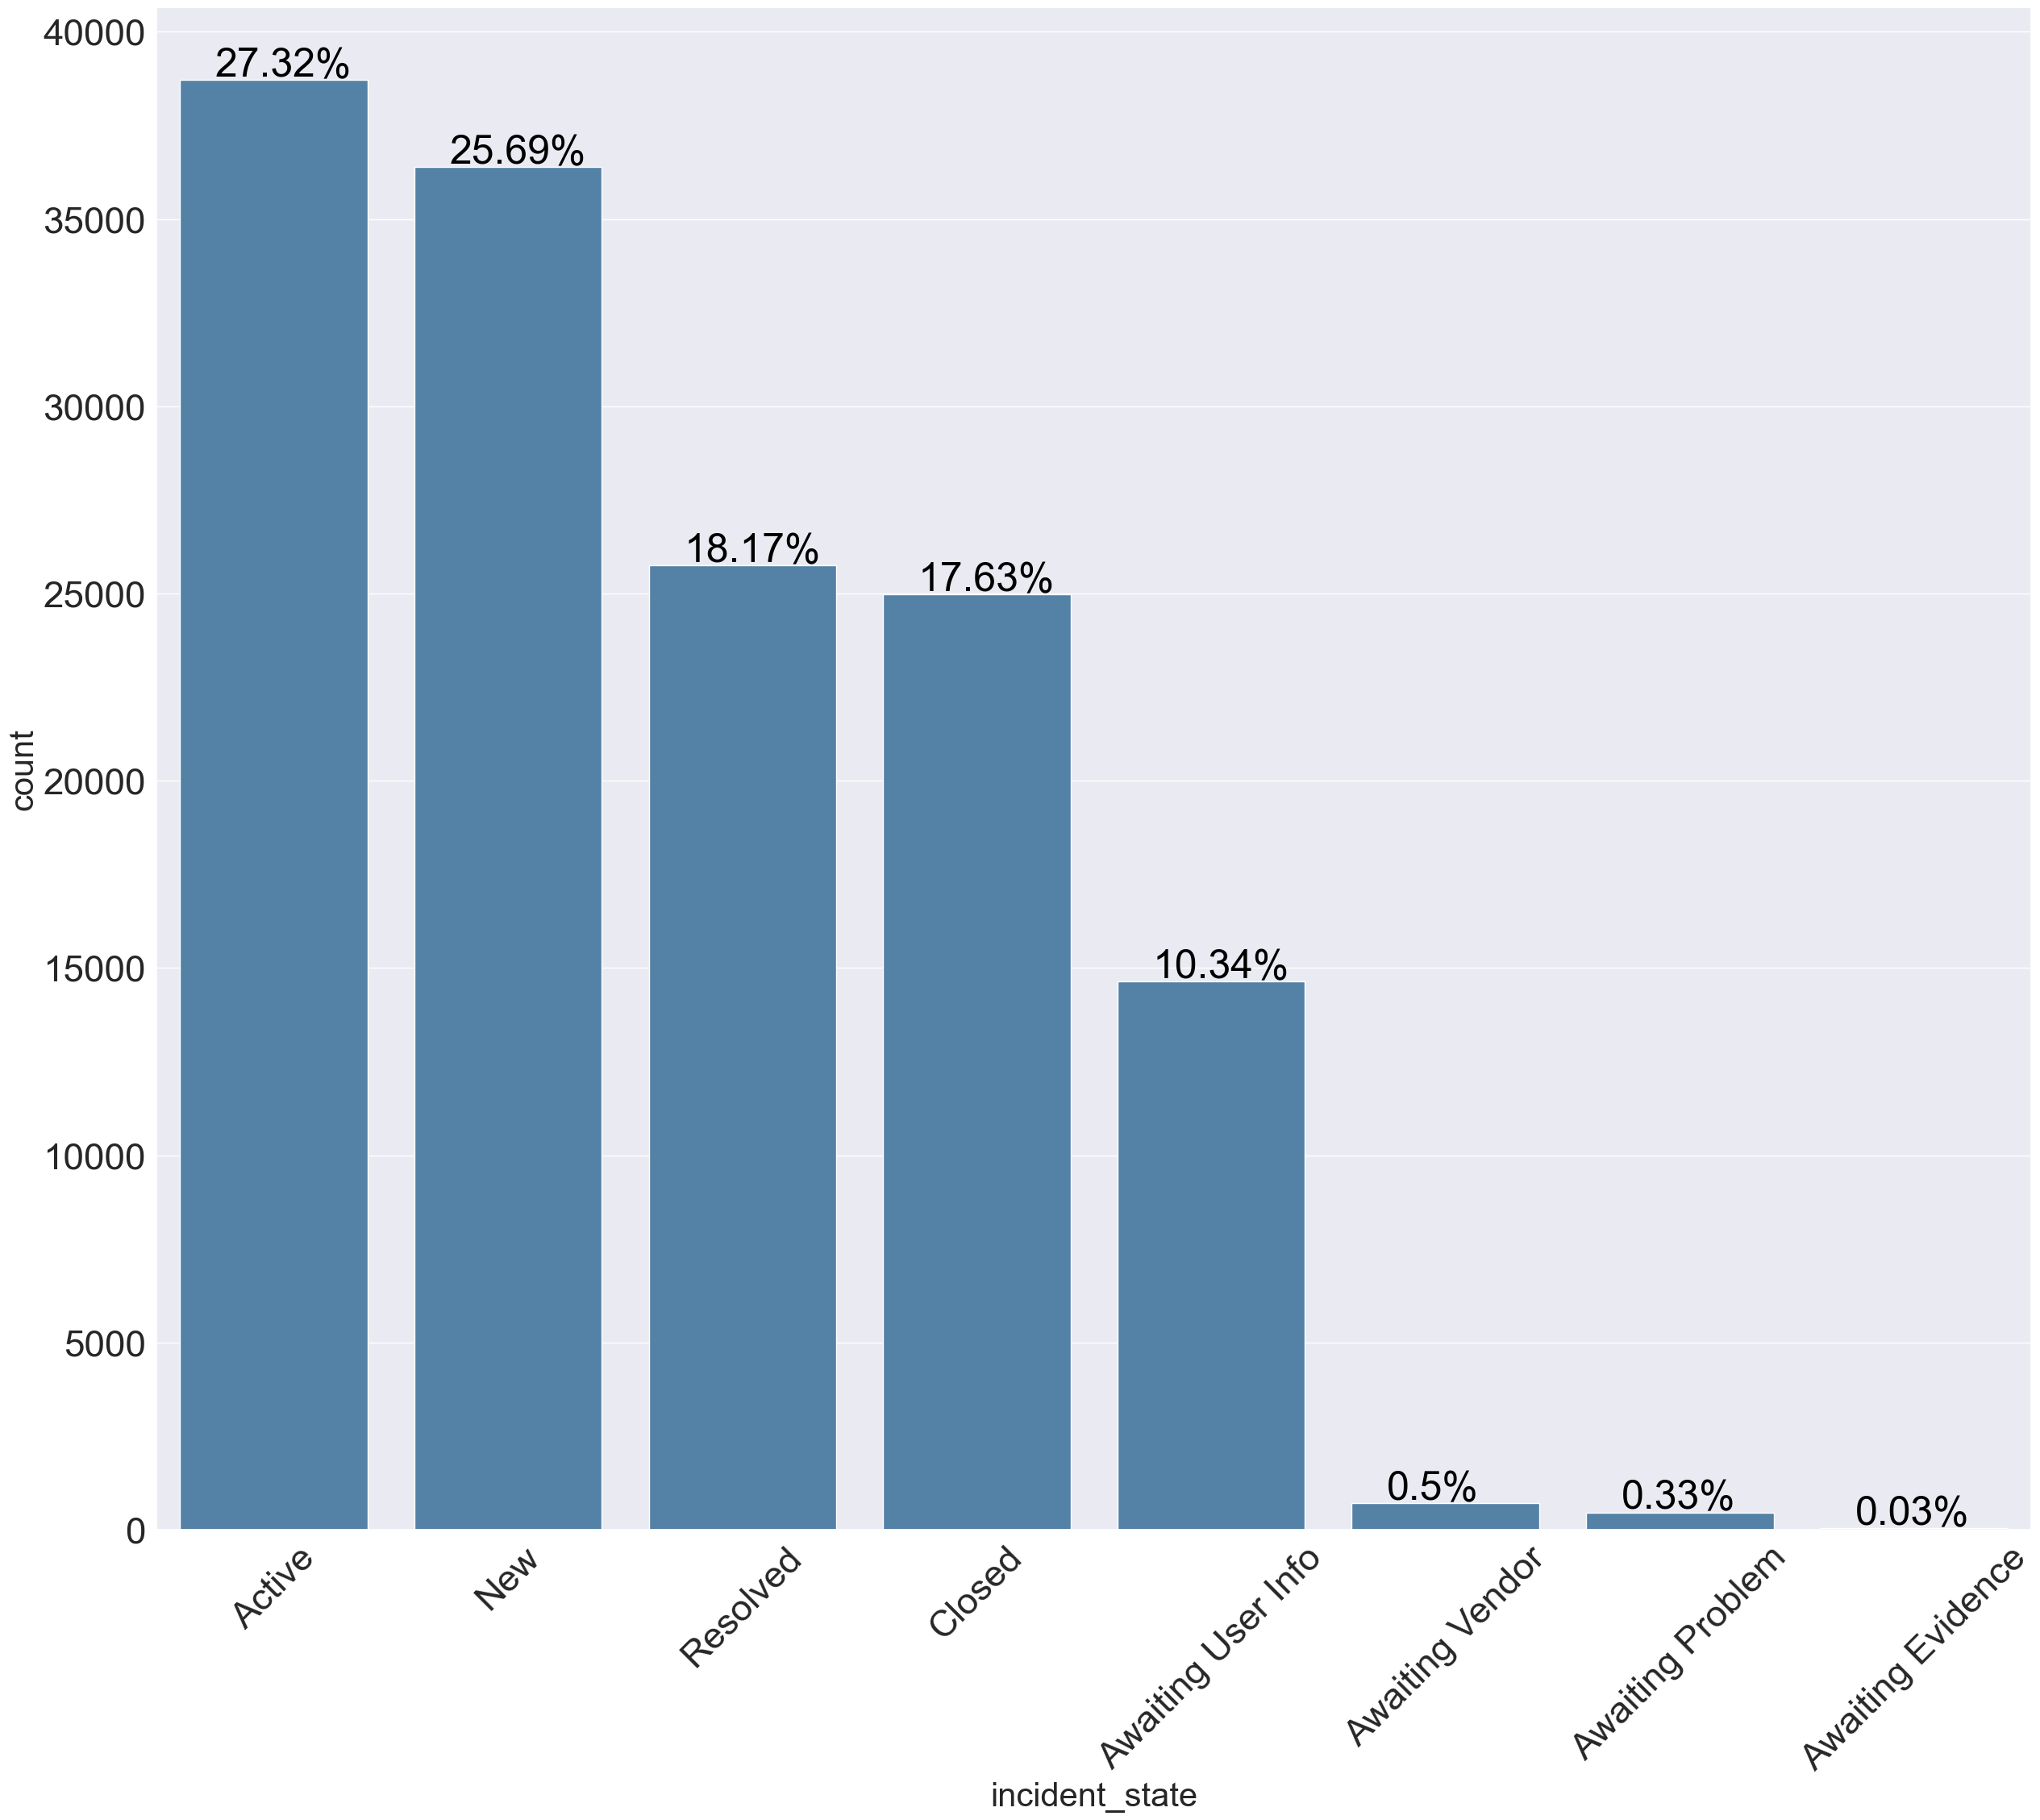

In [57]:
ascending_order = inc_eventdf['incident_state'].value_counts().sort_values(ascending=False).index
plot1 =sns.countplot(data = inc_eventdf, x = 'incident_state',order = ascending_order,color= "steelblue")
plt.xticks(rotation=45)
bar_perc(plot1)

### Unable to get fuction bar_perc to work while "order" parameter is used.

fig, axes = plt.subplots(2,2)

sns.countplot(ax=axes[0,0],data = inc_closed, x ='impact' ,color= "steelblue",order = ['1 - High','2 - Medium','3 - Low '])
sns.countplot(ax=axes[0,1],data = inc_closed, x ='contact_type' ,color= "steelblue",order = ['Phone','Self service','Email','Direct opening '])
sns.countplot(ax=axes[1,0],data = inc_closed, x ='urgency' ,color= "steelblue",order = ['1 - High','2 - Medium','3 - Low '])
sns.countplot(ax=axes[1,1],data = inc_closed, x ='priority' ,color= "steelblue",order = ['1 - Critical','2 - High','3 - Moderate','4 - Low'])


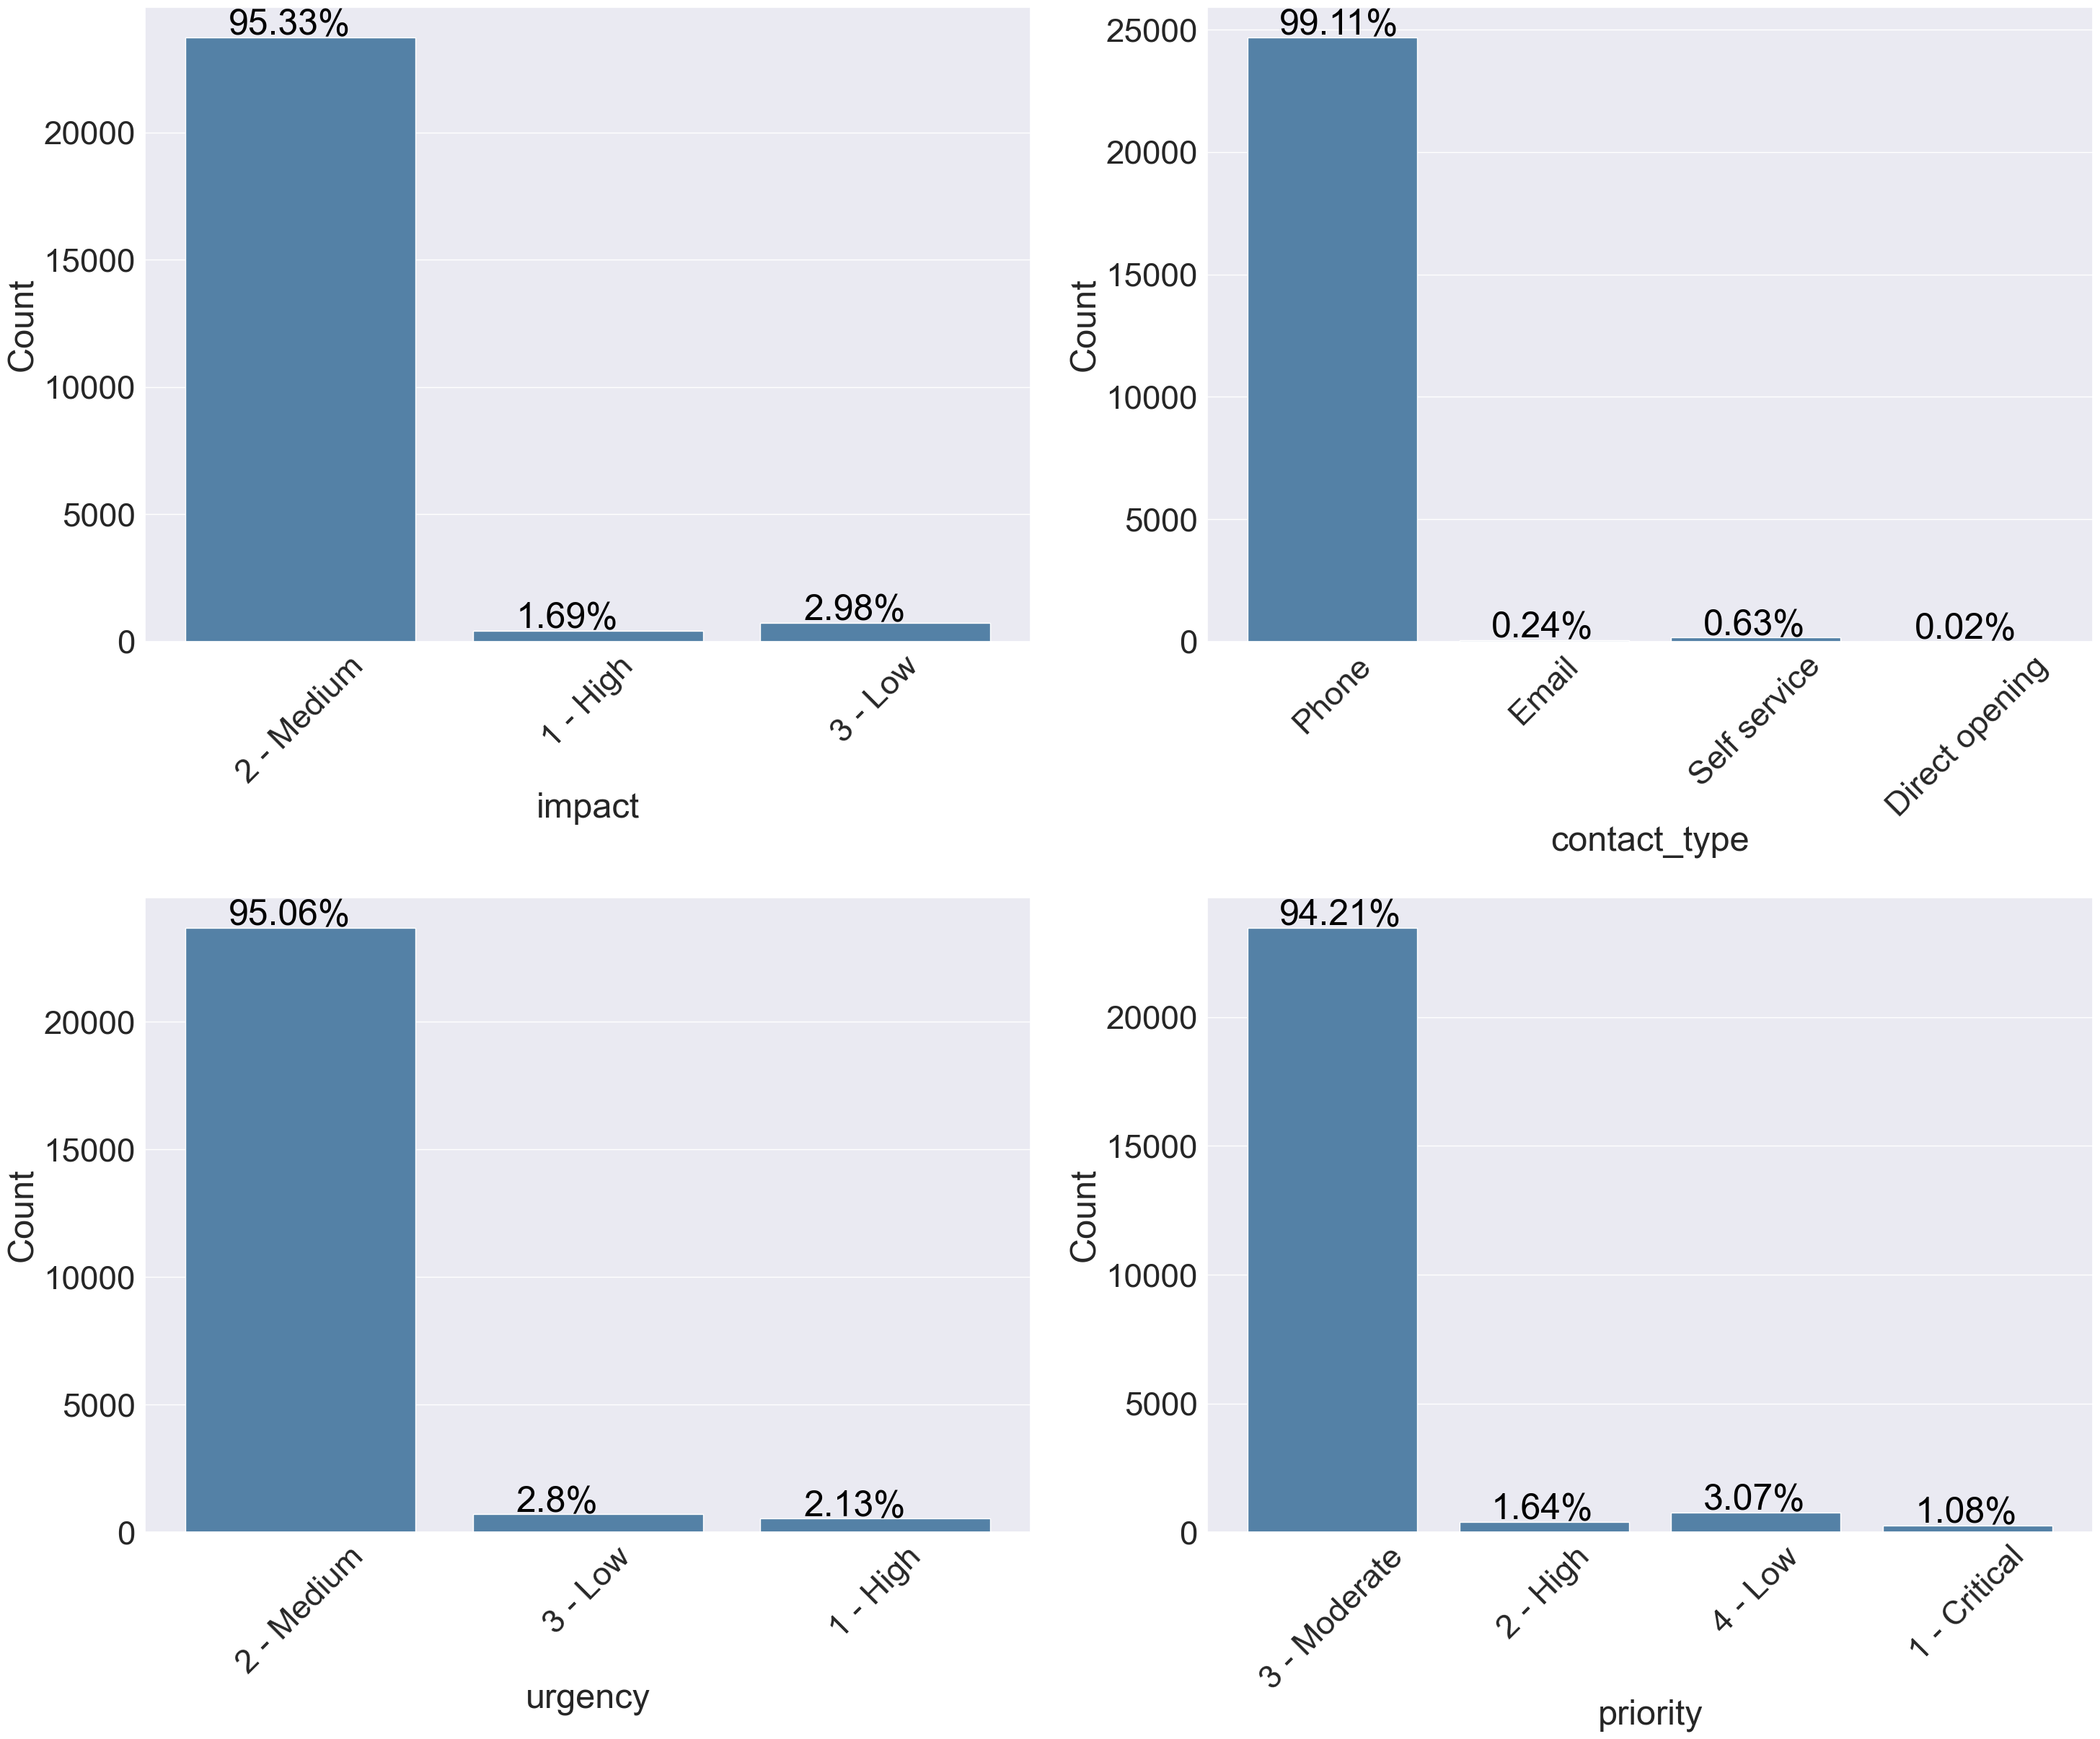

In [58]:
colname = ['impact','contact_type','urgency','priority']
order_list =[['1 - High','2 - Medium','3 - Low '],['Phone','Self service','Email','Direct opening '],['1 - High','2 - Medium','3 - Low '],['1 - Critical','2 - High','3 - Moderate','4 - Low']]


for i,j in enumerate(colname):
    plt.subplot(2,2,i+1)
    
    ax= sns.countplot(data = inc_closed, x = j,color= "steelblue") ##,order = order_list[i] (if this is added there is error)
    plt.ylabel("Count",fontsize=35)  
    plt.xlabel((j),fontsize=35) 
    plt.xticks(rotation=45)
   
    plt.margins(0.05)
    bar_perc(ax)

plt.tight_layout()

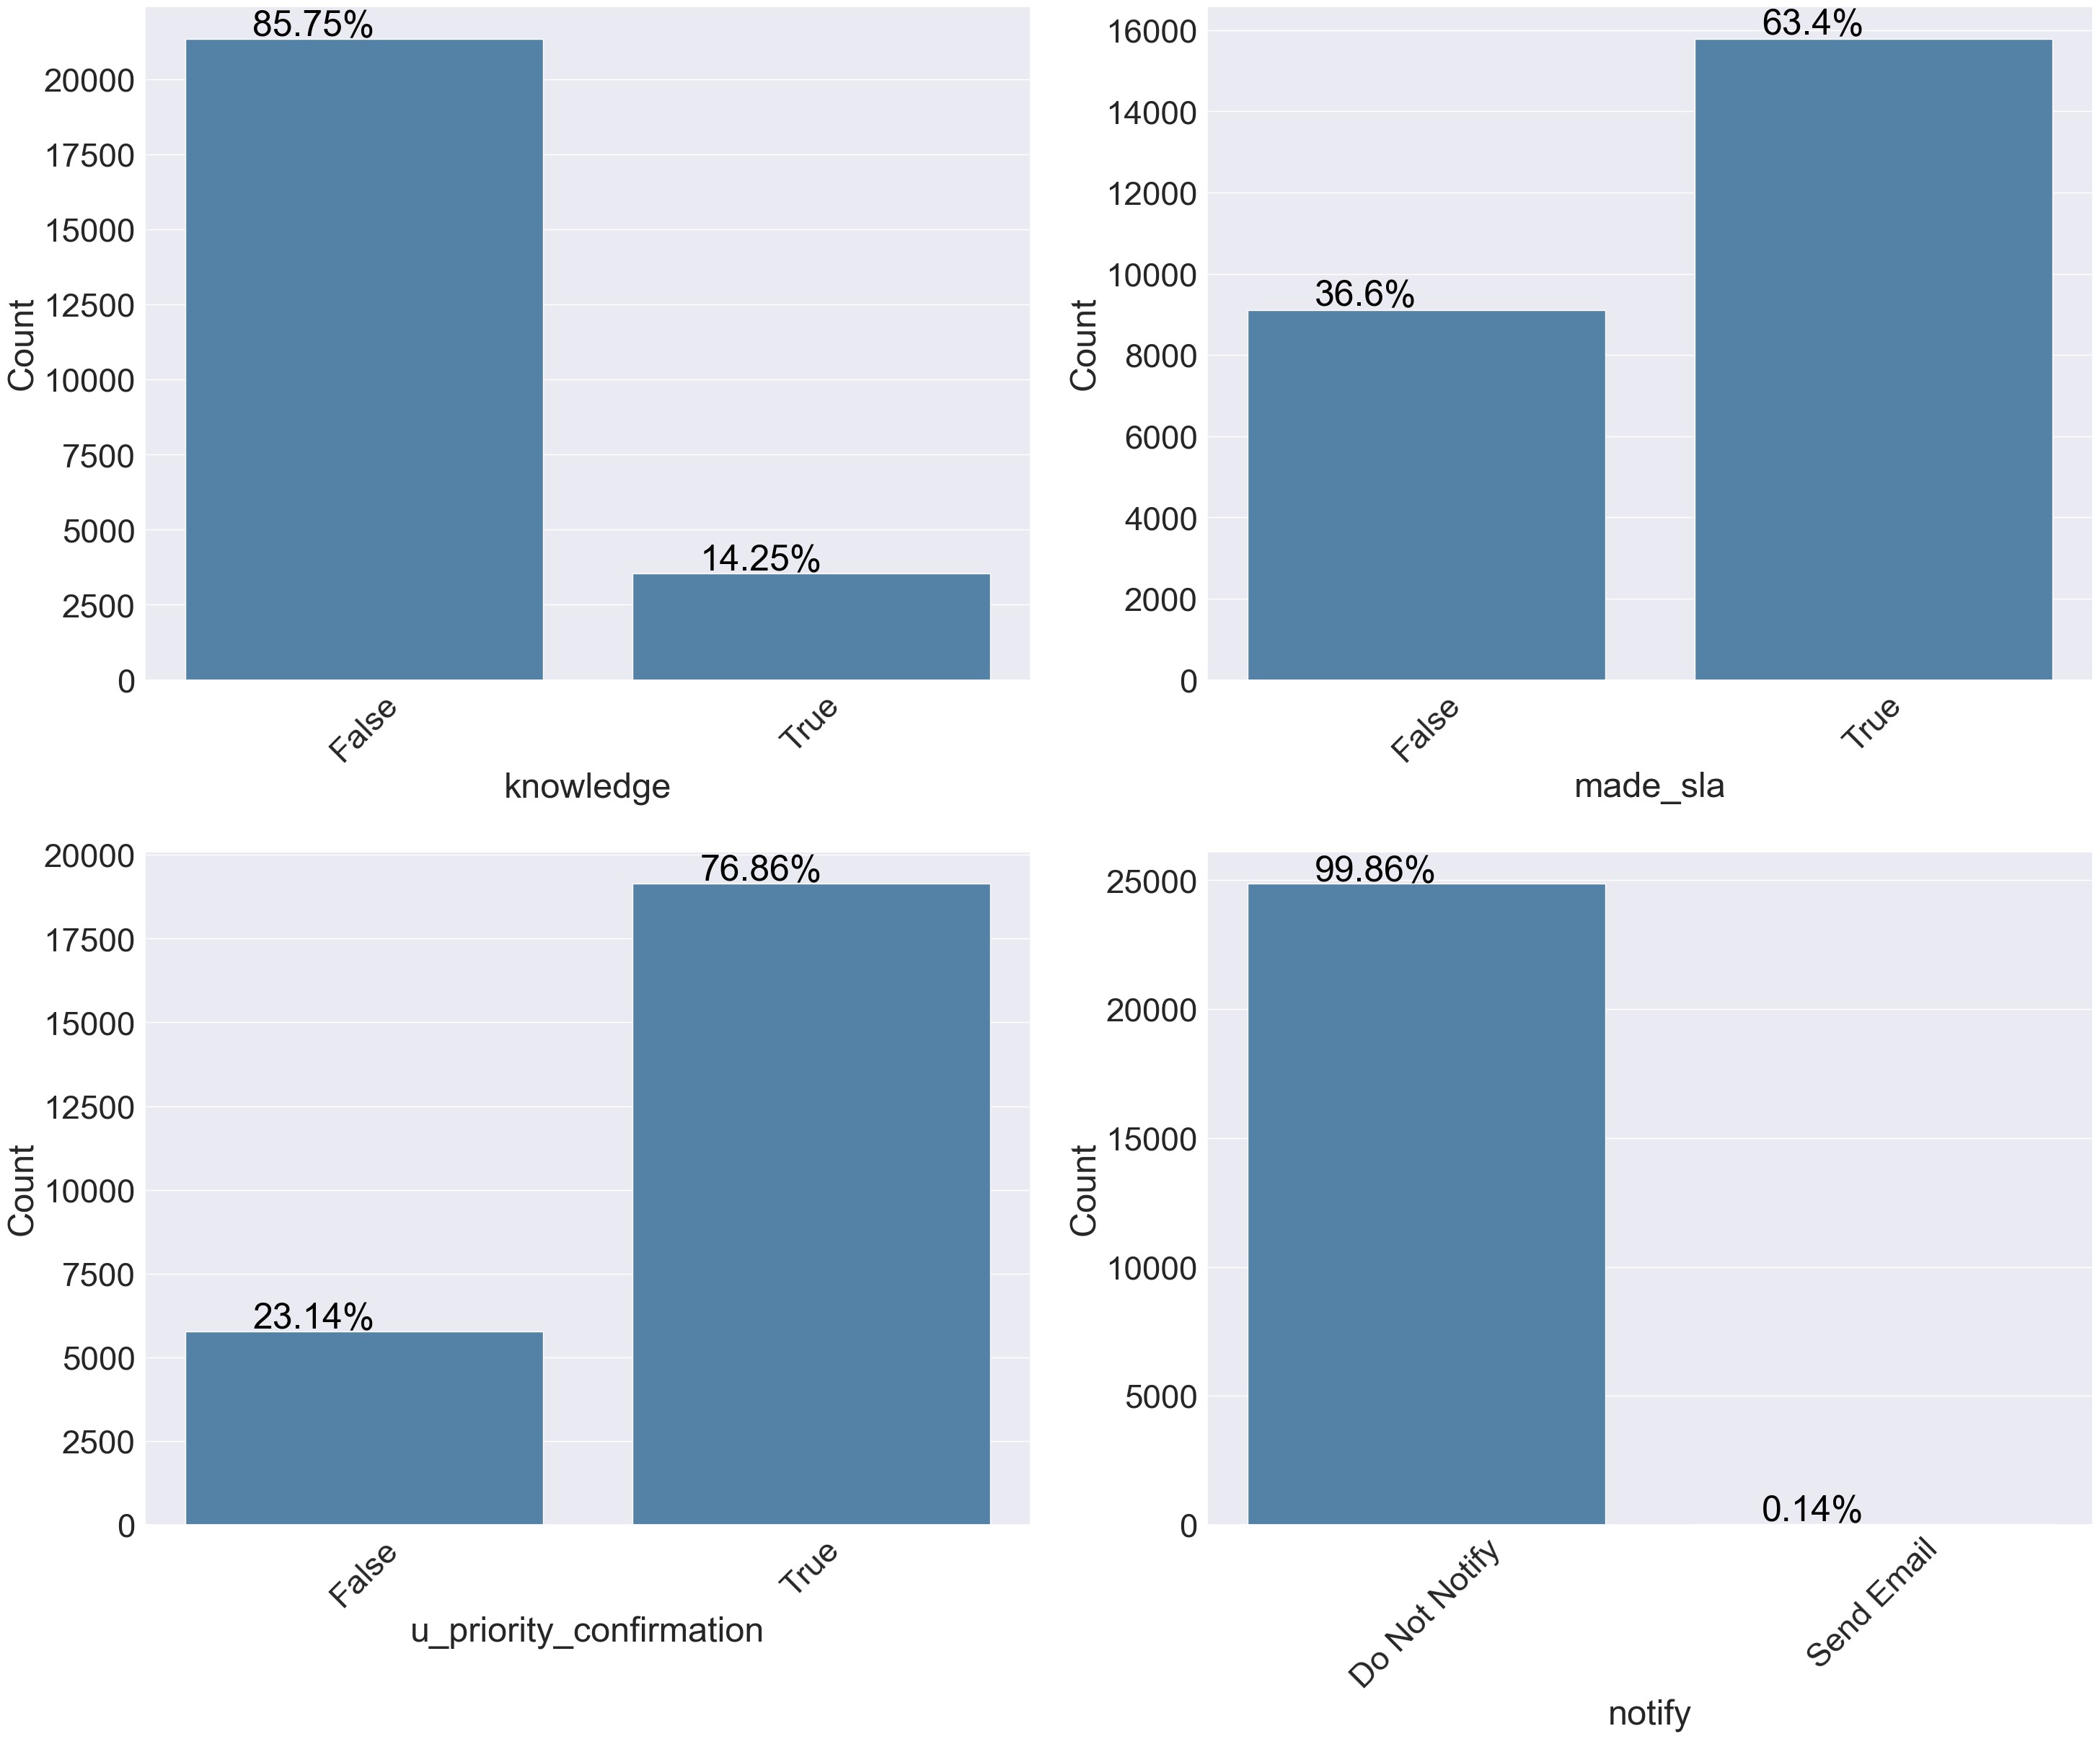

In [59]:
colname = ['knowledge','made_sla','u_priority_confirmation','notify']


for i,j in enumerate(colname):
    plt.subplot(2,2,i+1)
    ax = sns.countplot(data = inc_closed, x = j,color= "steelblue")
    bar_perc(ax)
    plt.ylabel("Count",fontsize=35)  
    plt.xlabel((j),fontsize=35) 
    plt.xticks(rotation=45)
    
    plt.margins(0.05)

plt.tight_layout()



In [60]:
def ecdf(data):
    n= len(data)
    x = np.sort(data)
    y = np.arange(1,n+1) /n
    
    return x,y


### Distribution of number of tickets opened every hour of the day.

In [61]:
def ecdf_plot(colname):
    for i,j in enumerate(colname):
        plt.subplot(2,2,i+1)
        x,y = ecdf(inc_closed[j])
        ax = plt.plot(x,y,marker='.',linestyle='none')
        plt.xlabel((j),fontsize=35)
        plt.ylabel("ECDF",fontsize=35)
        plt.margins(0.2)
        
        
        

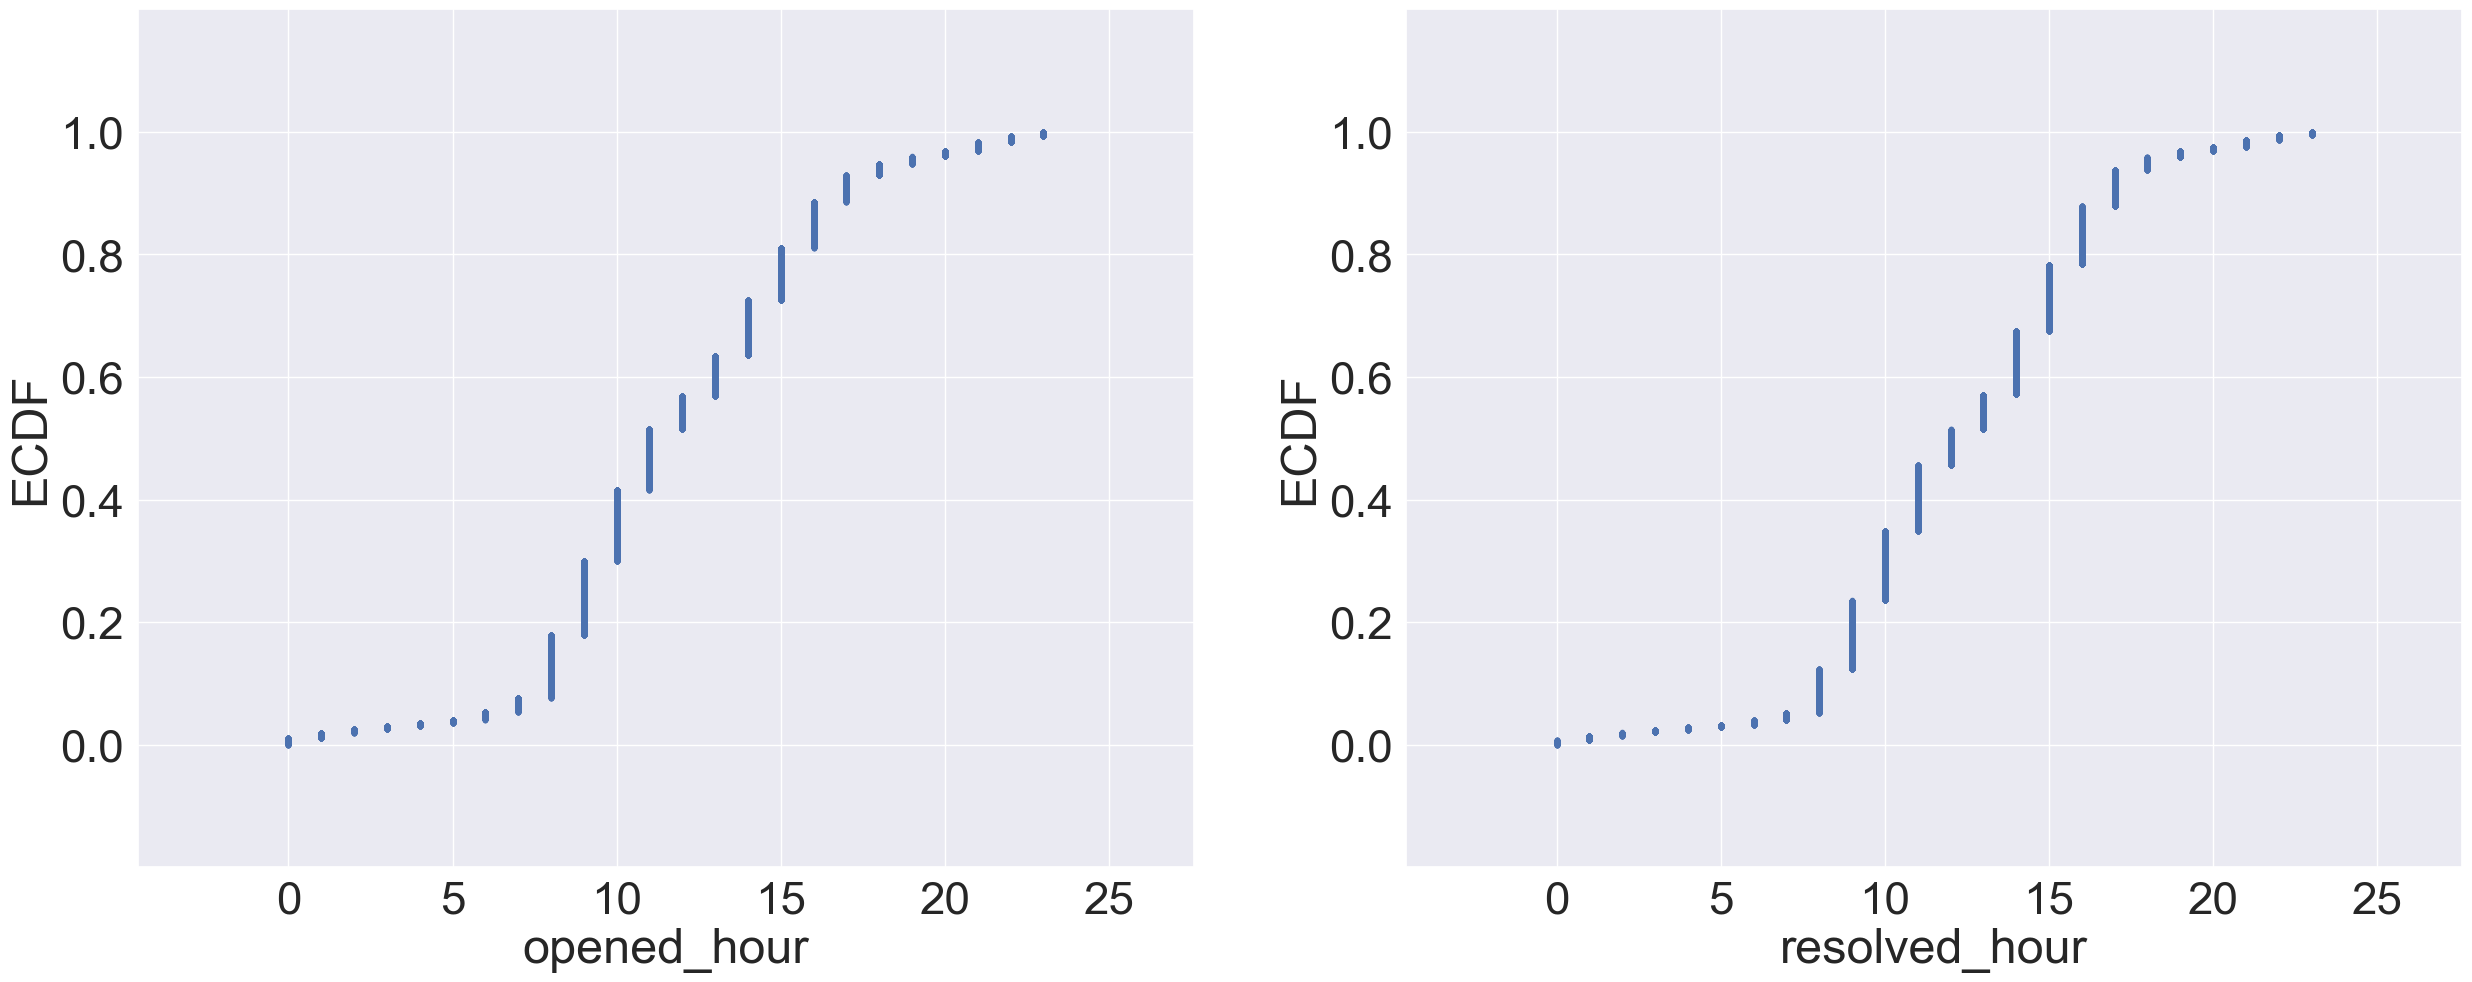

In [62]:
inc_closed['opened_hour']= inc_closed.opened_at.dt.hour
inc_closed['resolved_hour']= inc_closed.resolved_at.dt.hour

colname =['opened_hour','resolved_hour']
ecdf_plot(colname)

As, seen in  first plot for opened_hour you can see that most of the ticket's almost 80% of it was opened after 1000hrs(10 AM) in the morning.

its similar in case of resolved_hours , most of the tickets are resolved after 10 

In [63]:
inc_closed['days_closed_at'] = ((inc_closed['closed_at'] - inc_closed['opened_at'])).dt.days
inc_closed['seconds_closed_at'] = ((inc_closed['closed_at'] - inc_closed['opened_at'])).dt.seconds

inc_closed['Closing time (min)'] = ((inc_closed['days_closed_at']*24*60))+(inc_closed['seconds_closed_at']/60)
inc_closed['Closing time (min)'] = inc_closed['Closing time (min)'].astype('int64')


inc_closed['days_resolved_at'] = ((inc_closed['resolved_at'] - inc_closed['opened_at'])).dt.days
inc_closed['seconds_resolved_at'] = ((inc_closed['resolved_at'] - inc_closed['opened_at'])).dt.seconds

inc_closed['resolving time (min)'] = ((inc_closed['days_resolved_at']*24*60))+(inc_closed['seconds_resolved_at']/60)
inc_closed['resolving time (min)'] = inc_closed['resolving time (min)'].astype('int64')





In [64]:
inc_closed1 = inc_closed.copy()

inc_closed1 = inc_closed1.drop(["opened_at","sys_updated_at",'sys_created_by','sys_created_at','caused_by','assigned_to','subcategory','caller_id', 'opened_by','problem_id','rfc','vendor','u_symptom','cmdb_ci','resolved_at','closed_at','days_closed_at','seconds_closed_at','days_resolved_at','seconds_resolved_at'],axis=1)


In [73]:
column_type = ["notify",'contact_type',"sys_updated_by","resolved_by","closed_code","assignment_group","priority","location","category","impact","urgency"]

for i,j in enumerate(column_name):
    inc_closed1[j] = inc_closed1[j].astype(str)
    


## Preprocessing Data

In [74]:

column_name = ["urgency","impact","category","location","resolved_by","priority","assignment_group","closed_code","sys_updated_by",'notify','contact_type','number','incident_state','active','made_sla','knowledge','u_priority_confirmation']


from sklearn.preprocessing import LabelEncoder
lb_make = LabelEncoder()

for i,j in enumerate(column_name):
    inc_closed1[j] = lb_make.fit_transform(inc_closed1[j])


    



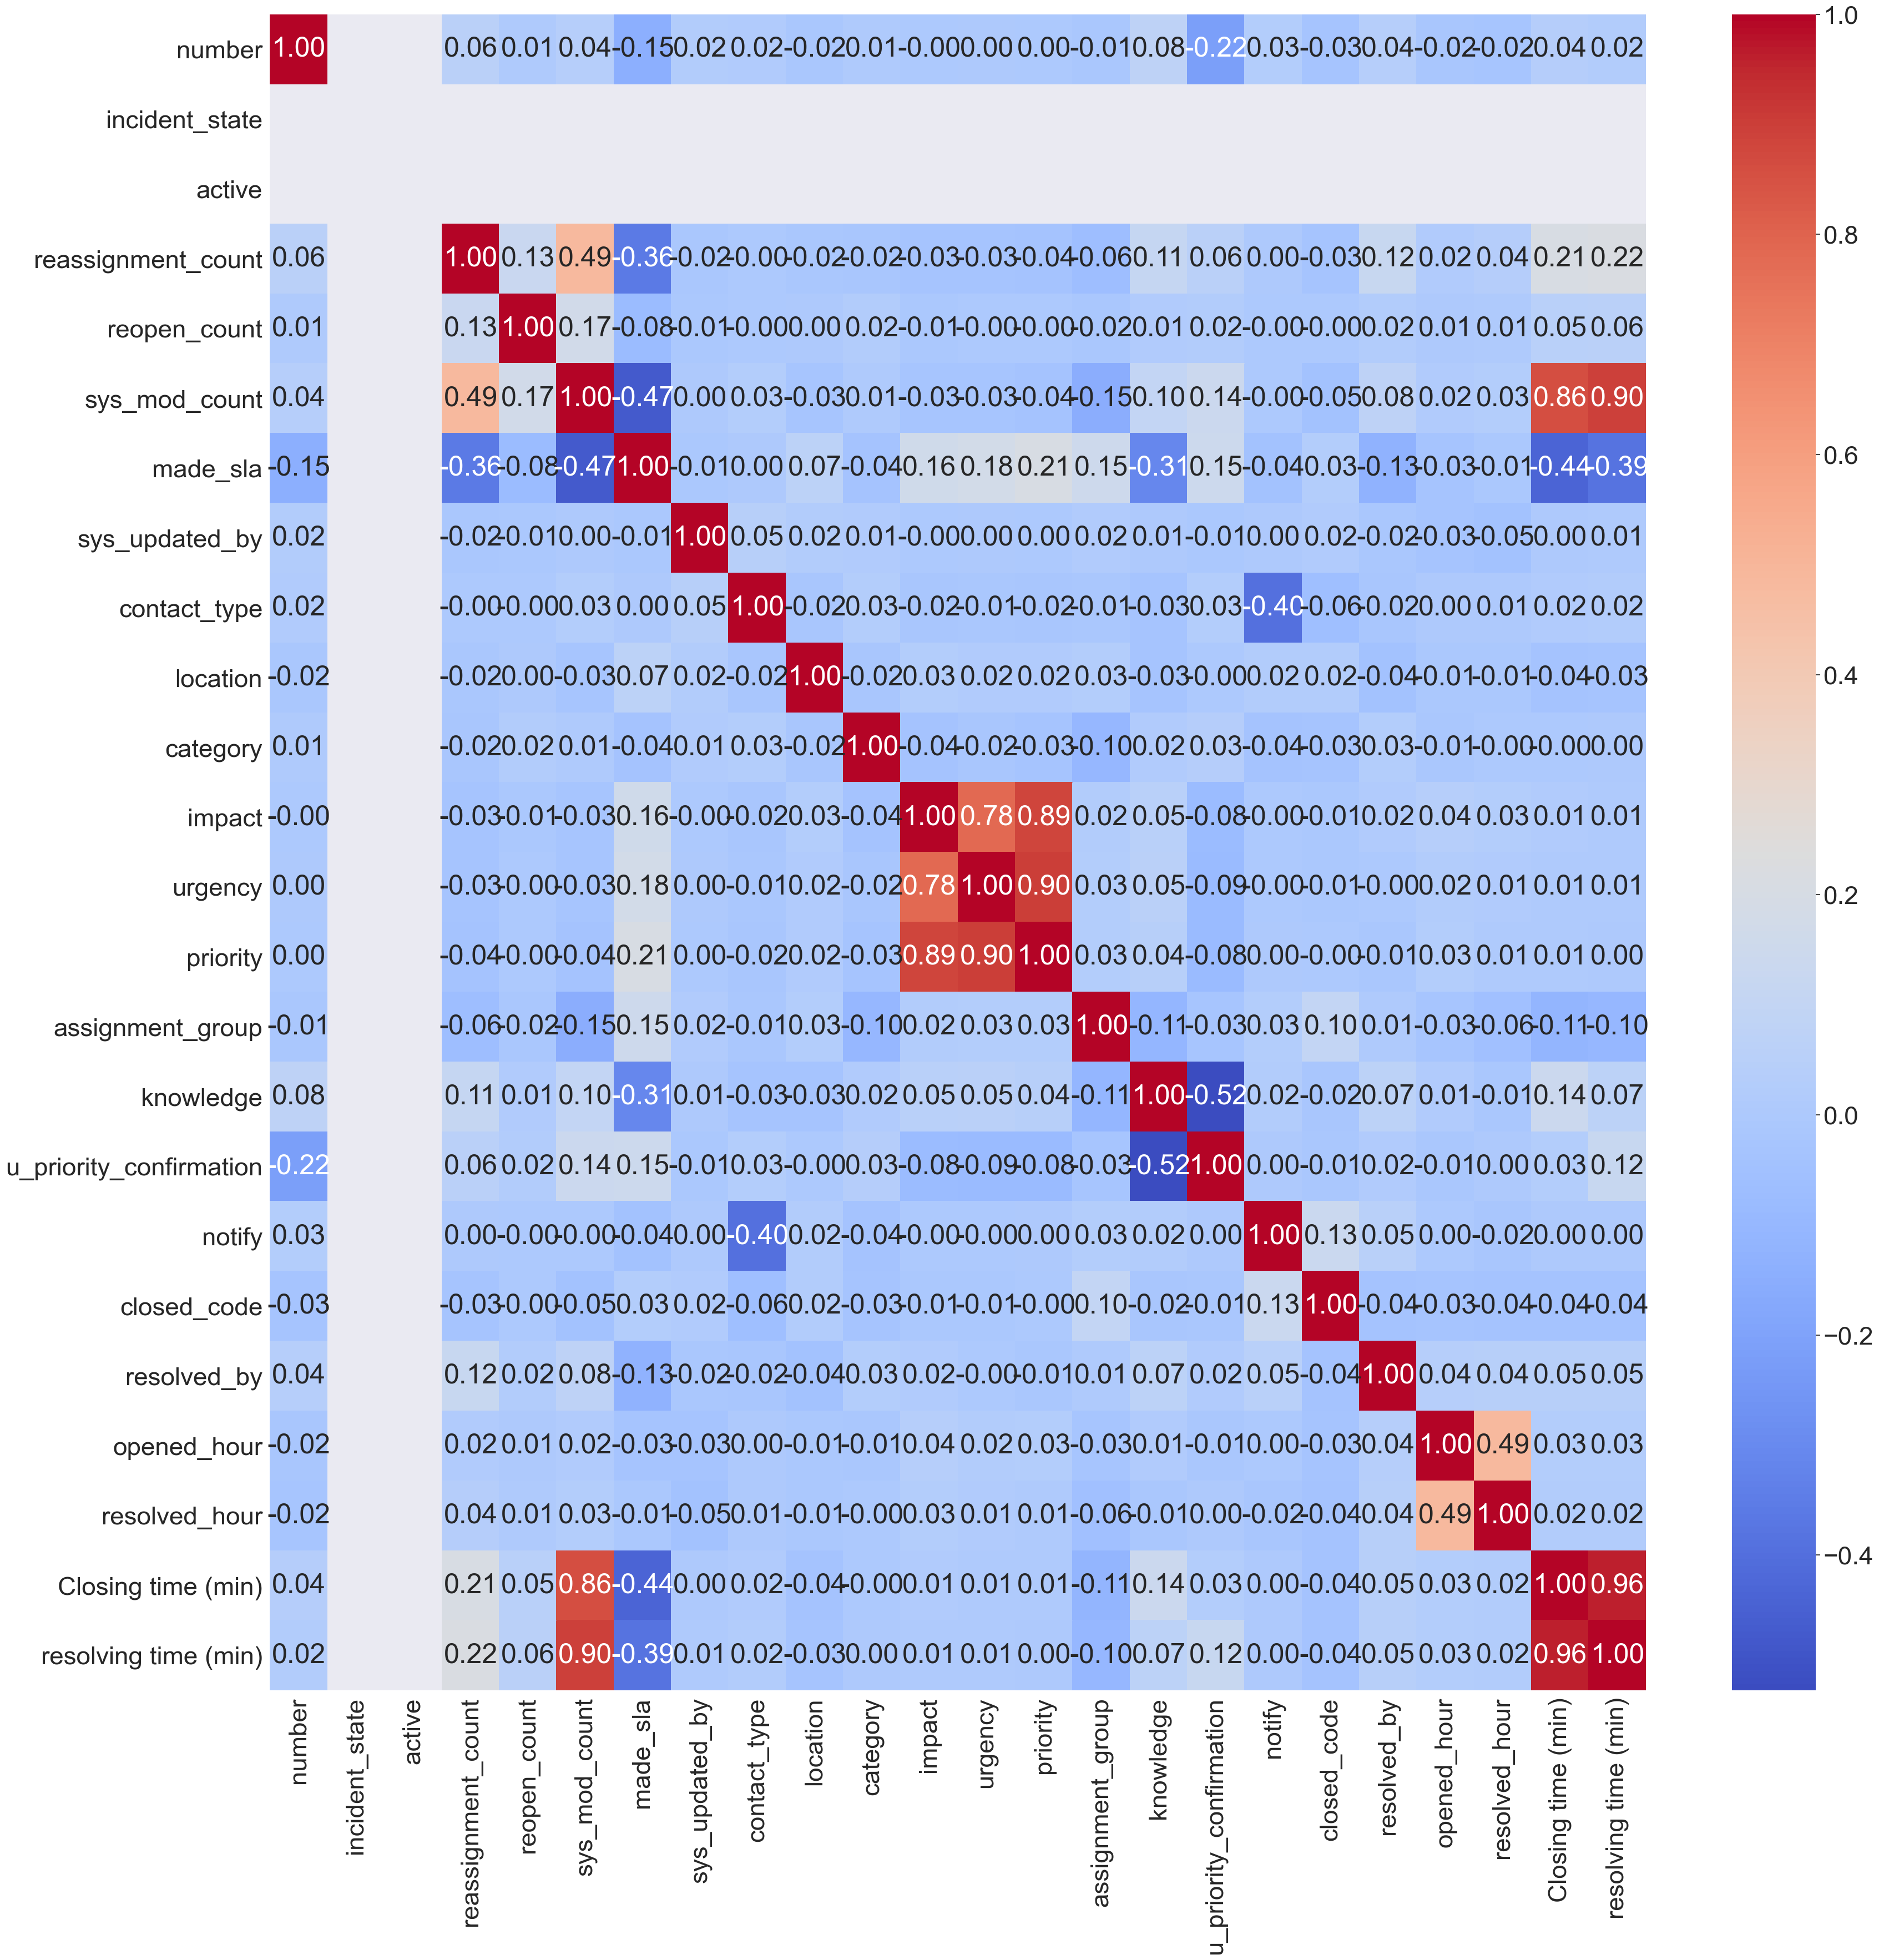

In [75]:

g = sns.heatmap(inc_closed1.corr(),annot=True,fmt = ".2f", cmap = "coolwarm")
fig=plt.gcf()
fig.set_size_inches(40,40)
plt.show()

## Machine Learning

In [76]:
X = inc_closed1.drop(["Closing time (min)"], axis = 1)
y = inc_closed1["Closing time (min)"]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3,random_state = 42)

## GradientBoosting

In [88]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import accuracy_score,classification_report
from sklearn.model_selection import cross_val_score


gradient = GradientBoostingRegressor()


In [92]:
score = cross_val_score(gradient,X_train,y_train,cv=5)

print("Cross-validation scores: {}".format(score))
print("Average cross-validation score: {:.4f}".format(score.mean()))

Cross-validation scores: [0.92389237 0.9436646  0.98209359 0.95735761 0.90531803]
Average cross-validation score: 0.9425


# Random Forest

In [99]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
hyperparametres = { 'n_estimators':20 }
regressor = RandomForestRegressor(**hyperparametres)
regressor.fit(X_train,y_train)
score=regressor.score(X_test,y_test)
score

0.9527685980602426

In [100]:
hyperparametres = { 'n_estimators':20 }
regressor = RandomForestRegressor(**hyperparametres)
score = cross_val_score(regressor,X_train,y_train,cv=5)

print("Cross-validation scores: {}".format(score))
print("Average cross-validation score: {:.4f}".format(score.mean()))

Cross-validation scores: [0.94172597 0.95674865 0.98240974 0.98107297 0.92250785]
Average cross-validation score: 0.9569


## Linear Regression

In [102]:

from sklearn.linear_model import LinearRegression

regressor = LinearRegression()
regressor.fit(X_train, y_train)
score = regressor.score(X_test, y_test)
score

0.9539822699466425

In [103]:
regressor = LinearRegression()
score = cross_val_score(regressor,X_train,y_train,cv=5)

print("Cross-validation scores: {}".format(score))
print("Average cross-validation score: {:.4f}".format(score.mean()))

Cross-validation scores: [0.91881282 0.92095361 0.96977981 0.95623168 0.8943406 ]
Average cross-validation score: 0.9320


## KNN Neighbor

In [104]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=12,metric='euclidean') # Maximum accuracy for n=10
knn.fit(X_train,y_train)
knn.score(X_test, y_test)

0.0034801231428189

In [107]:
knn = KNeighborsClassifier(n_neighbors=12,metric='euclidean')
score = cross_val_score(knn,X_train,y_train,cv=5)

print("Cross-validation scores: {}".format(score))
print("Average cross-validation score: {:.4f}".format(score.mean()))

C:\Users\Rahul KG\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Cross-validation scores: [0.00573559 0.00430293 0.00745841 0.00545037 0.00516351]
Average cross-validation score: 0.0056


## LASSO

In [97]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha = 10)
lasso.fit(X_train,y_train)
print('Train score: {:.4f}'.format(lasso.score(X_train,y_train)))
print('Test score: {:.4f}'.format(lasso.score(X_test, y_test)))

Train score: 0.9318
Test score: 0.9539


In [98]:
lasso = Lasso(alpha = 10)
score = cross_val_score(lasso,X_train,y_train,cv=5)

print("Cross-validation scores: {}".format(score))
print("Average cross-validation score: {:.4f}".format(score.mean()))

Cross-validation scores: [0.91877179 0.92101228 0.96980996 0.95621797 0.89428837]
Average cross-validation score: 0.9320
